In [1]:
# Load the libraries
import spatialdata as sd
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from spatialdata import get_extent
from spatialdata import bounding_box_query
from spatialdata import match_element_to_table
import spatialdata_plot
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from datatree import DataTree
from scipy.stats import spearmanr
from scipy.spatial.distance import cosine
from sklearn.neighbors import KernelDensity
from easydecon.easydecon import *
from easydecon.config import *
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent
from mpl_toolkits.axes_grid1.inset_locator import inset_axes




pd.set_option('display.max_rows', 10)

/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_n_jobs(5) #if you have more than 5 cores, you can increase this number

In [3]:
# load a compatible color map for the spatial data
new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")

# Loading the data and QC
Now we load the spatial data and the target data. We use 8um bin size which is an acceptable resolution. Set the sample id and point spaceranger output directory. 

You should change this based on your dataset location.

In [4]:
bin_size=8
sample_id="sampleP2"

sdata=spatialdata_io.visium_hd("../../sampleP2/binned_outputs/",fullres_image_file="../../sampleP2/Visium_HD_Human_Colon_Cancer_tissue_image.btf",
                               bin_size=bin_size,dataset_id=sample_id,load_all_images=True)
sdata

/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SpatialData object
├── Images
│     ├── 'sampleP2_cytassist_image': DataArray[cyx] (3, 3000, 3200)
│     ├── 'sampleP2_full_image': DataTree[cyx] (3, 48740, 75250), (3, 24370, 37625), (3, 12185, 18812), (3, 6092, 9406), (3, 3046, 4703)
│     ├── 'sampleP2_hires_image': DataArray[cyx] (3, 3886, 6000)
│     └── 'sampleP2_lowres_image': DataArray[cyx] (3, 389, 600)
├── Shapes
│     └── 'sampleP2_square_008um': GeoDataFrame shape: (545913, 1) (2D shapes)
└── Tables
      └── 'square_008um': AnnData (545913, 18085)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        sampleP2_hires_image (Images), sampleP2_square_008um (Shapes)
    ▸ 'downscaled_lowres', with elements:
        sampleP2_lowres_image (Images), sampleP2_square_008um (Shapes)
    ▸ 'global', with elements:
        sampleP2_cytassist_image (Images), sampleP2_full_image (Images), sampleP2_square_008um (Shapes)

In [5]:
# to align the high resolution image with the spatial data, we need to run this part
data_extent=get_extent(sdata[f"{sample_id}_square_00{bin_size}um"])

queried_cytassist = bounding_box_query(
    sdata[f"{sample_id}_full_image"],
    min_coordinate=[data_extent["x"][0], data_extent["y"][0]],
    max_coordinate=[data_extent["x"][1], data_extent["y"][1]],
    axes=("x", "y"),
    target_coordinate_system="global",
)

sdata["queried_cytassist"]=queried_cytassist

We need to normalize the data before running the spatial deconvolution. We will use the normalization method from scanpy. 

We can also add the qc metrics. You can use this for extra filtering.

In [6]:
for table in sdata.tables.values():
   table.var_names_make_unique()
   sc.pp.calculate_qc_metrics(table, inplace=True)
   sc.pp.filter_genes(table, min_cells=10) #you may increase this number for a more stringent filtering
   sc.pp.filter_cells(table, min_counts=10) #you may increase this number for a more stringent filtering
   sc.pp.normalize_total(table, inplace=True,target_sum=1e4)
   sc.pp.log1p(table)
   #sc.pp.scale(table)
   #sc.pp.pca(table)
   #sc.pp.neighbors(table)
   #sc.tl.umap(table)

#here we filter the spatial data to only include the cells that are in the table
sdata.shapes[f"{sample_id}_square_00{bin_size}um"]=sdata.shapes[f"{sample_id}_square_00{bin_size}um"][sdata.shapes[f"{sample_id}_square_00{bin_size}um"].index.isin(sdata.tables[f"square_00{bin_size}um"].obs["location_id"])]

/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `sampleP2_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


# Visualize the tissue image
Now visualize the full image and the expressed region. "queried_cytassist" image that we created before can be used to visualize the expressed region.

INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              
INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    


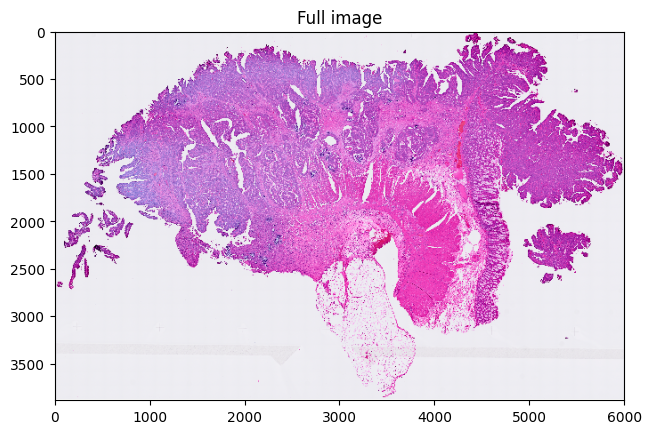

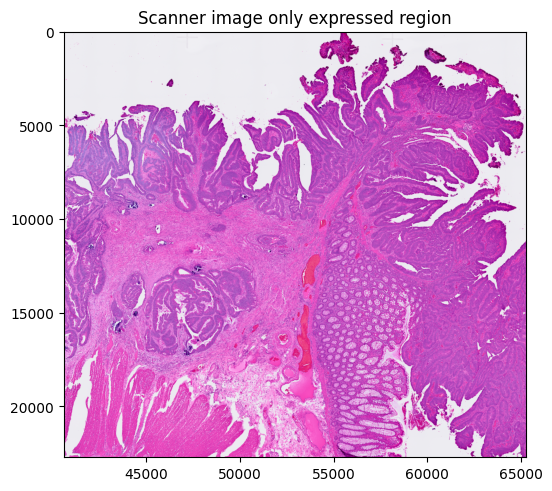

In [7]:
sdata.pl.render_images(f"{sample_id}_hires_image").pl.show( title="Full image")
sdata.pl.render_images("queried_cytassist").pl.show( title="Scanner image only expressed region")



We can run Easydecon on the subregion of the data. We also also use the entire section to run the spatial deconvolution but it is faster to run on the region of interest.
Lets select a subregion. You can check the coordinates of the region of interest from the image above.

# Load the deseq results from the Anndata file
You can also use the deseq results from the csv or excel file of Scanpy.
Here we load the Anndata file from Pelka study. We will use this data for cell type transfer.

In [8]:
#This sample object already contains DESEQ data for top level clusters, so we don't need to run the calculation again.
#you can simply load an Excel or csv file with the DESEQ results and add it to the sample object, from Scanpy or even Seurat
adata=sc.read_h5ad('adata3.h5ad')
adata

AnnData object with n_obs × n_vars = 371223 × 43282
    obs: 'X', 'Y', 'ClusterFull', 'ClusterMidway', 'ClusterTop', 'celltype'
    uns: 'celltype_colors', 'dendrogram_ClusterTop', 'dendrogram_celltype', 'pca', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs'

Now reading the marker genes from the Pelka study. We will use these genes for cell type transfer. We will use the top 60 genes per cluster.

In [9]:
markers_df_top60lf=read_markers_dataframe(sdata,adata=adata,top_n_genes=60,sort_by_column='scores')

#markers_df_top60lf is the dataframe that contains the top 60 genes that are differentially expressed in the Pelka study.
markers_df_top60lf.index.value_counts()
# You see there are 7 top level clusters.

Unique cell types detected in the dataframe:
['Epi', 'TNKILC', 'Plasma', 'Myeloid', 'B', 'Strom', 'Mast']
Categories (7, object): ['B', 'Epi', 'Mast', 'Myeloid', 'Plasma', 'Strom', 'TNKILC']


group
B          60
Epi        60
Mast       60
Myeloid    60
Plasma     60
Strom      60
TNKILC     60
Name: count, dtype: int64

# Find the most likely spots of top level markers
Now we get the summed expression for this sample. 

This will return a dataframe with the sum of marker expression for the entire tissue and this data will automatically be added to the spatial data object i.e. sdata.

In [10]:
# these parameters are usually good enough for most of the cases. You can run on a regular computer.
df_cluster_sum=common_markers_gene_expression_and_filter(sdata,markers_df_top60lf,num_permutations=1000,aggregation_method="sum",alpha=0.01,subsample_size=50000)

new version


Subsample 50000/50000 for TNKILC: 100%|██████████| 200/200 [00:01<00:00, 199.47it/s]


Adding results to table.obs of sdata object


In [11]:
#the dataframe looks like this. The columns are the clusters and the rows are the spatial bins.
df_cluster_sum.head()

B        Epi  Mast  Myeloid  Plasma      Strom  \
s_008um_00301_00321-1  0.0   0.000000   0.0      0.0     0.0   0.000000   
s_008um_00526_00291-1  0.0  54.109360   0.0      0.0     0.0   0.000000   
s_008um_00078_00444-1  0.0   0.000000   0.0      0.0     0.0   0.000000   
s_008um_00128_00278-1  0.0   0.000000   0.0      0.0     0.0  55.177582   
s_008um_00052_00559-1  0.0  65.178329   0.0      0.0     0.0   0.000000   

                       TNKILC  
s_008um_00301_00321-1     0.0  
s_008um_00526_00291-1     0.0  
s_008um_00078_00444-1     0.0  
s_008um_00128_00278-1     0.0  
s_008um_00052_00559-1     0.0

# Visualize the most likely spots of top level markers
We can visualize any cluster we can, for example Epithelial cells. Here "Epi" column used to visualize the epithelial cells and you may select any cell type you want to visualize. These shows the most likely location of the epithelial cells (alpha < 0.0001)

INFO     Using matplotlib                                                                                          


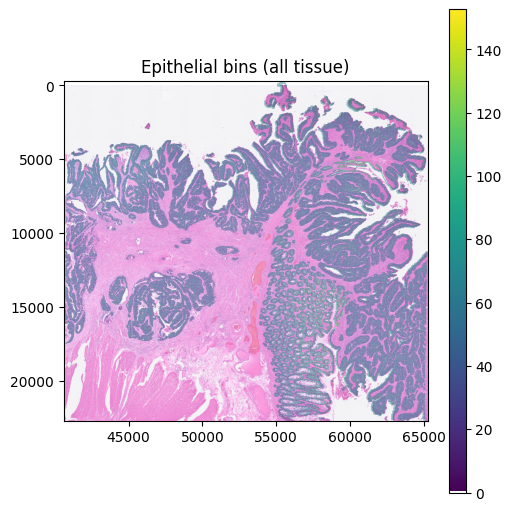

In [12]:
sdata.pl.render_images("queried_cytassist",alpha = 0.6).pl.render_shapes(
            f"{sample_id}_square_00{bin_size}um", color="Epi",cmap=new_cmap,method="matplotlib",scale=0.8
        ).pl.show(coordinate_systems="global", title="Epithelial bins (all tissue)",legend_fontsize=8,figsize=(5,5))


A similar visualization can be done for the other cell types. Here we visualize the Myeloid bins.

INFO     Using matplotlib                                                                                          


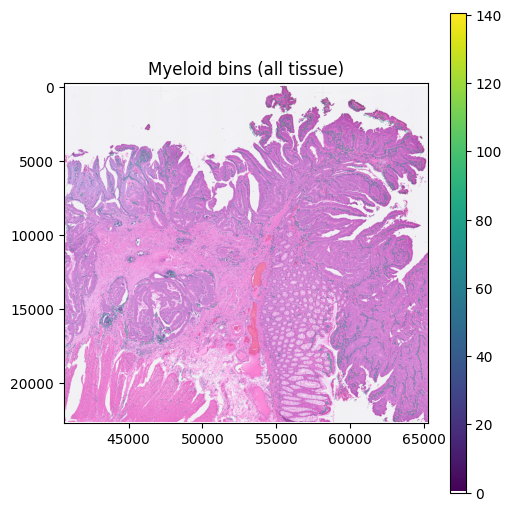

In [13]:
sdata.pl.render_images("queried_cytassist",alpha = 0.7).pl.render_shapes(
            f"{sample_id}_square_00{bin_size}um", color="Myeloid",cmap=new_cmap,method="matplotlib",scale=0.8
        ).pl.show(coordinate_systems="global", title="Myeloid bins (all tissue)",legend_fontsize=8,figsize=(5,5))


# Increasing granularity of top level cell types

Now lets pull out Myeloid cells from the Pelka study object. We will increase granularity of the Myeloid types by using mid level markers. However, we have to run a quick deseq analysis to get the mid level markers.

In [14]:
adata_myeloid = adata[adata.obs['ClusterTop'] == 'Myeloid', :].copy()

In [15]:
sc.tl.rank_genes_groups(adata_myeloid, groupby="ClusterMidway", method="wilcoxon")

In [16]:
# Top see the granuality better and shorten the runtime, we create a subset of the spatial data object

sdata_small = sdata.query.bounding_box(
   min_coordinate=[42000, 12000], max_coordinate=[50000, 18000], axes=("x", "y"), target_coordinate_system="global"
)

We are going to pull out the differentially expressed genes in the myleoid anndata object after wilcoxon test.

In [17]:
markers_df_myeloid_top60lf=read_markers_dataframe(sdata_small,adata=adata_myeloid,top_n_genes=60,sort_by_column='scores')
markers_df_myeloid_top60lf.index.value_counts()
# There are 4 clusters in the myeloid group

Unique cell types detected in the dataframe:
['Macro', 'Mono', 'DC', 'Granulo']
Categories (4, object): ['DC', 'Granulo', 'Macro', 'Mono']


group
DC         60
Granulo    60
Macro      60
Mono       60
Name: count, dtype: int64

Now we are transferring labels from the deseq table to the spatial data object.

In [18]:
df_cluster_wjaccard=get_clusters_by_similarity_on_tissue(sdata_small,markers_df=markers_df_myeloid_top60lf,method="wjaccard",common_group_name="Myeloid")

Processing spots with Myeloid != 0
Number of threads used: 5
Batch size: 1000


100%|██████████| 4318/4318 [00:13<00:00, 326.73it/s]


Adding results to table.obs of sdata object


In [19]:
# data frame is similar to the mean expression one.
df_cluster_wjaccard.head()

Macro      Mono        DC   Granulo
s_008um_00219_00193-1  0.014807  0.003430  0.006271  0.002652
s_008um_00209_00071-1  0.009468  0.000242  0.009691  0.003507
s_008um_00190_00220-1  0.005781  0.004076  0.003094  0.000542
s_008um_00247_00288-1  0.014679  0.000652  0.004252  0.000125
s_008um_00234_00119-1  0.010122  0.001546  0.005516  0.003857

The latest method is automatically added to the spatial data object. However, we can add it manually as well using add_df_to_spatialdata function. This will replace the identical columns with the new data.

In [20]:
add_df_to_spatialdata(sdata_small,df_cluster_wjaccard)

DataFrame added to SpatialData object
Index(['Macro', 'Mono', 'DC', 'Granulo'], dtype='object')


We can now assign myeloid sub-clusters based on their similarity and write them into a new column **easydecon_wjaccard_myleoid_clusters** in the spatial data object.

In [21]:
assign_clusters_from_df(sdata_small,df_cluster_wjaccard,results_column="easydecon_wjaccard_myleoid_clusters")

easydecon_wjaccard_myleoid_clusters
s_008um_00282_00228-1                                 NaN
s_008um_00196_00202-1                                 NaN
s_008um_00285_00131-1                                 NaN
s_008um_00311_00071-1                                 NaN
s_008um_00219_00193-1                               Macro
...                                                   ...
s_008um_00246_00187-1                                 NaN
s_008um_00268_00286-1                                 NaN
s_008um_00316_00292-1                                 NaN
s_008um_00243_00304-1                               Macro
s_008um_00260_00044-1                               Macro

[56702 rows x 1 columns]

INFO     Using matplotlib                                                                                          


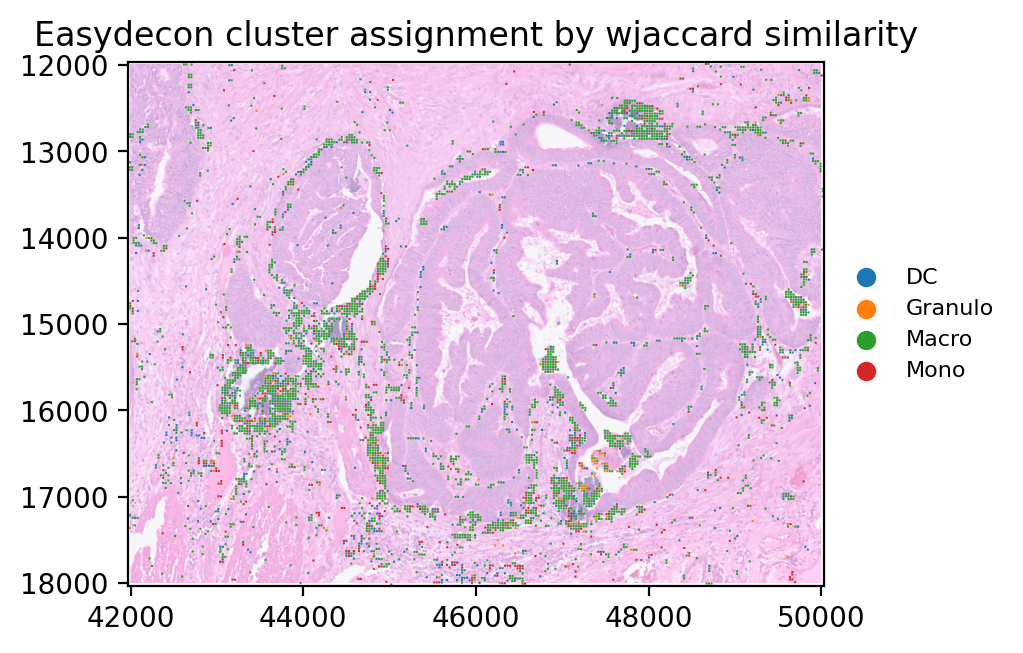

In [22]:
sdata_small.pl.render_images("queried_cytassist",alpha = 0.4).pl.render_shapes(
            f"{sample_id}_square_00{bin_size}um", color="easydecon_wjaccard_myleoid_clusters",method="matplotlib",scale=0.8,na_color= (0.0, 0.0, 0.0, 0.0)
        ).pl.show(coordinate_systems="global", title="Easydecon cluster assignment by wjaccard similarity", legend_fontsize=8,figsize=(5,5),dpi=200,na_in_legend=False)


# Predicting the cell type proportions
We can also predict the cell type proportions for Myeloid clusters.

In [23]:
# We use common_group_name="Myeloid" to make sure only Myeloid hotspots are used for proportion estimation.
df_cluster_mye_proportions=get_proportions_on_tissue(sdata_small,markers_df=markers_df_myeloid_top60lf,method="nnls",common_group_name="Myeloid",normalization_method="zscore")

Processing spots with Myeloid != 0
Running deconvolution with parallel processing...
Normalization method: zscore
Number of threads used: 5
Running deconvolution with method='nnls', alpha=0.1...


100%|██████████| 4318/4318 [00:00<00:00, 8287.16it/s]


Adding results to table.obs of sdata object
Deconvolution completed.


INFO     Using matplotlib                                                                                          


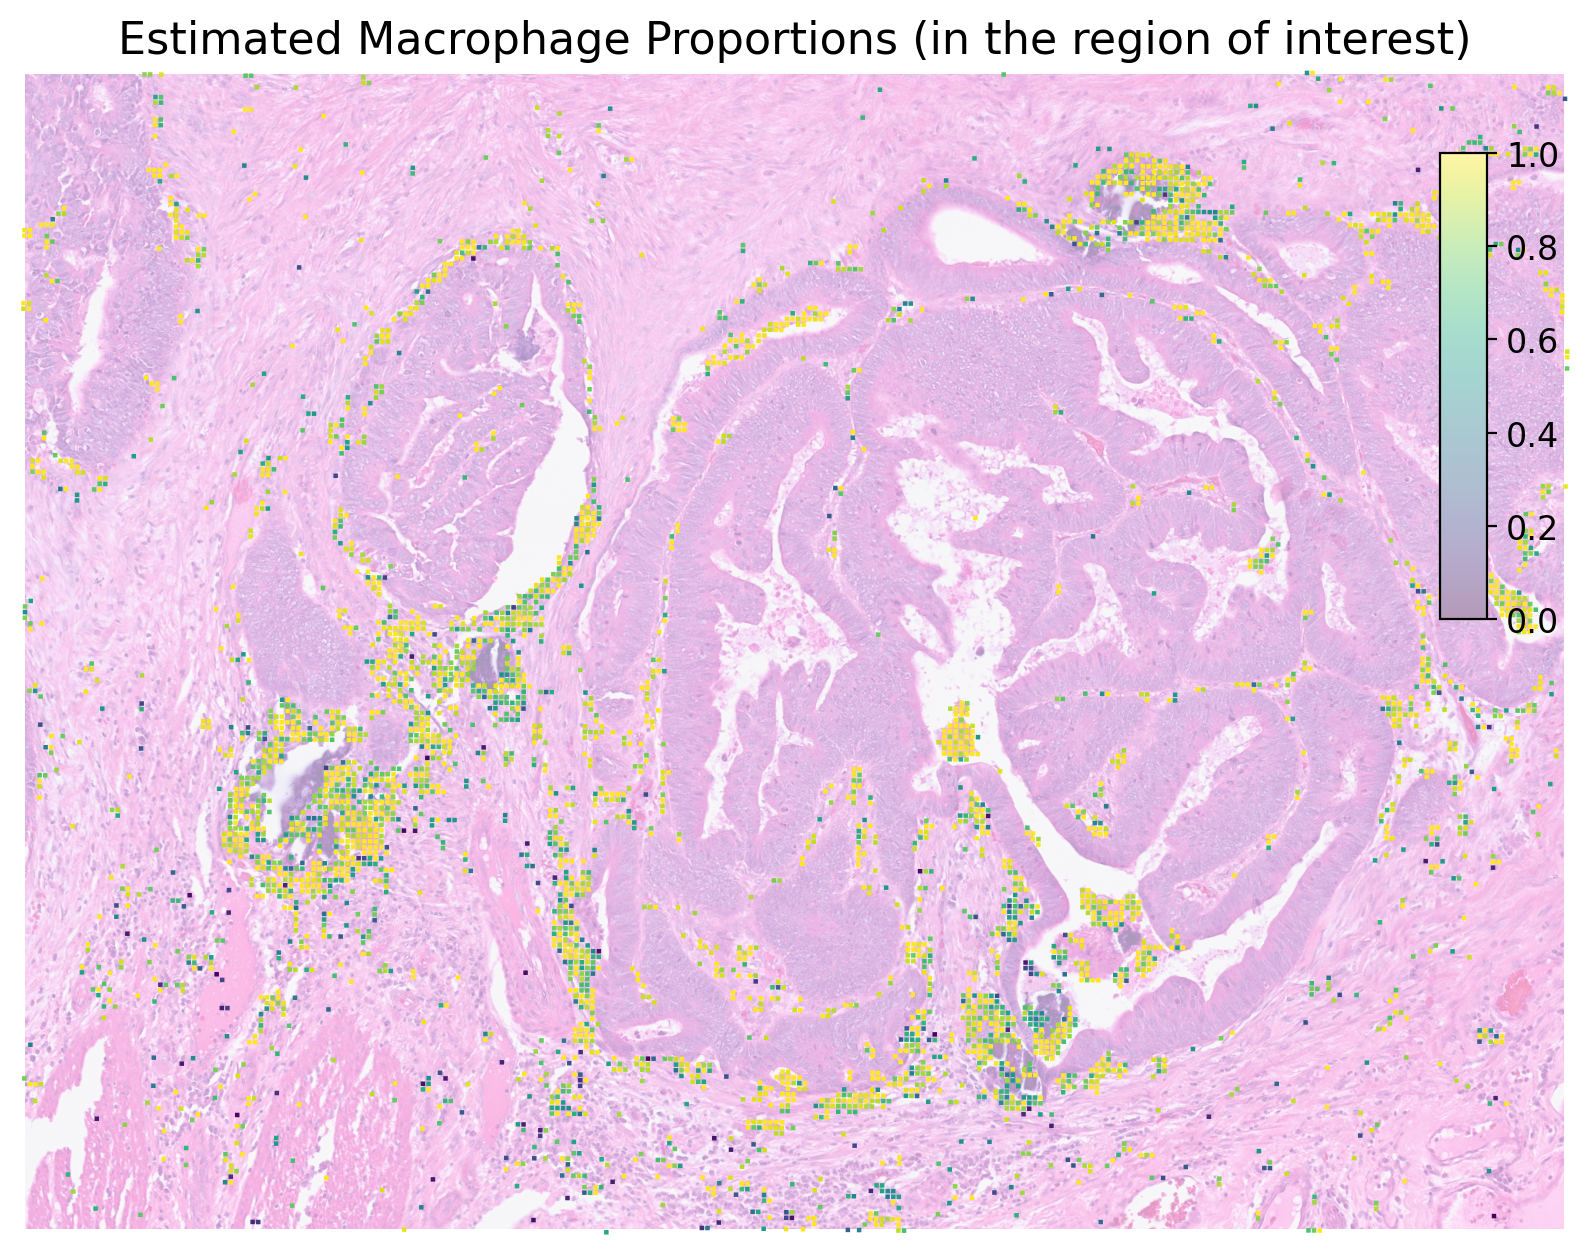

In [24]:
## Create a single figure for one plot
## Publication ready plot code, you may adjust for your needs
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Render the spatial plot and display it in the Axes
sdata_small.pl.render_images("queried_cytassist", alpha = 0.4).pl.render_shapes(
    f"{sample_id}_square_00{bin_size}um",
    color="Macro",  # Continuous feature
    cmap=new_cmap,      # Use a colormap suitable for continuous data
    na_color=(0.0, 0.0, 0.0, 0.0),
    method="matplotlib",
    scale=0.8,
).pl.show(
    coordinate_systems="global",
    title=None,
    legend_fontsize=None,
    figsize=None,
    dpi=200,
    return_ax=False,
    ax=ax,  # Pass the single Axes object
    colorbar=False  # Disable the default colorbar
)

# Ensure the image object from the spatial plot is captured
im = ax.images[0]  # Capture the first image object created by the plot

# Add a colorbar inside the plot
inset_ax = inset_axes(
    ax, width="3%", height="40%", loc="upper right", 
    borderpad=3    # Padding between the Axes and colorbar  # Adjust size and position
)


cbar = fig.colorbar(im, cax=inset_ax, orientation="vertical")
#cbar.set_label('Myeloid', fontsize=14)  # Label for the colorbar
cbar.ax.tick_params(labelsize=12,colors='black')  # Adjust tick size

# Customize the Axes appearance
ax.set_title('Estimated Macrophage Proportions (in the region of interest)', fontsize=16)  # Add a title for the plot
ax.axis('off')  # Remove ticks and borders

# Save the final figure
#plt.savefig(f"{sample_id}_macrophage_proportions_roi_nnls.pdf", dpi=300)

# Display the plot
plt.show()